In [1]:
import warnings
warnings.filterwarnings("ignore")

import gc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from pprint import pprint
from datetime import datetime as ddd
from itertools import combinations, product
from xgboost import plot_importance, XGBRegressor

from sklearn.metrics import r2_score as r2
from sklearn.metrics import mean_squared_error as mse
from sklearn.preprocessing import MinMaxScaler

In [2]:
#path = "../data/tables_consultants"
path = "../data/single_coda/"
window = 30
info = "coda_5_assistenza"
data_path = f"{path}/xgb_dataset_{window}_days_2021-09-01_2021-12-31_{info}.csv"
splitting = data_path.split("_")
beg = splitting.index("days")
end = splitting.index("coda")
dates = splitting[beg +1:end]
date_interval = dates[0] + "_" + dates[1]

In [3]:
df = pd.read_csv(data_path).sample(frac = 1, random_state = 42).reset_index(drop = True)
df["data"] = df["data"].apply(pd.to_datetime)

target = "RR_medio"

cols = [col for col in df.columns[2:] if "data" not in col and "collegato" not in col]
cols.remove(target)

In [4]:
df_masked = df[(df["data"] >= pd.to_datetime("2021-09-01")) & (df["data"] <= pd.to_datetime("2021-11-30"))]

X = df_masked[cols]
y = df_masked[target]

# find correlated features and keep only the first

new_cols = cols.copy()
m = X.corr(method = "spearman")

th = 0.6

for couple in combinations(cols, 2):
    f1, f2 = couple[0], couple[1]
    correlation = m[f1][f2]
    
    if np.abs(correlation) > th:    
        #print(f1, "***", f2, "correlation", correlation)
        try:
            new_cols.remove(f2)
        except ValueError:
            pass
        
print("Features before removal", len(cols))
print("Features after removal", len(new_cols))

Features before removal 11
Features after removal 6


In [5]:
for col in new_cols:  
    if any(s in col for s in ["ko", "cancellat", "non", "pausa"]):
           df[col] = -df[col]       

In [6]:
quantiles = np.linspace(0.1,0.9,9)

In [7]:
# train / validation / test split

n = df.shape[0]
train_fraction = 0.7
valid_fraction = (1 - train_fraction) / 2

n_train = int(n*train_fraction)
n_valid = int(n*valid_fraction)

df_train = df[:n_train]
df_valid = df[n_train : n_train + n_valid].reset_index(drop = True)
df_test  = df[n_train + n_valid:].reset_index(drop = True)

X_train = df_train[new_cols]
X_valid = df_valid[new_cols]
X_test  = df_test[new_cols]

y_train = df_train[target]
y_valid = df_valid[target]
y_test  = df_test[target]

In [8]:
best_set = [0.2, 0.0, 14, 0.8]

model = XGBRegressor(learning_rate = best_set[0],
                     min_split_loss = best_set[1], 
                     max_depth = best_set[2], 
                     subsample = best_set[3])
    
model.fit(X_train, y_train)
    
# for metric evaluation

y_pred_train = model.predict(X_train)
y_pred_valid = model.predict(X_valid)
y_pred_test  = model.predict(X_test)

In [9]:
# R2 score

r2_train = r2(y_pred_train, y_train)
r2_valid = r2(y_pred_valid, y_valid)
r2_test = r2(y_pred_test, y_test)

# last best value: (0.9999200382448091, 0.9639927181632918, 0.9718774726828501)

r2_train, r2_valid, r2_test

(0.9999631525129393, 0.9682083339592319, 0.9837143876536013)

In [10]:
# RMSE

rmse_train = mse(y_pred_train, y_train, squared = False)
rmse_valid = mse(y_pred_valid, y_valid, squared = False)
rmse_test  = mse(y_pred_test,  y_test,  squared = False)

rmse_train, rmse_valid, rmse_test, rmse_valid/rmse_train, rmse_test/rmse_train

(0.0006069401075715407,
 0.01729606360707728,
 0.01338184935495351,
 28.497150528215133,
 22.04805579334066)

In [11]:
assert r2_test > 0, f"R2 score on test set is negative: {r2_test}"

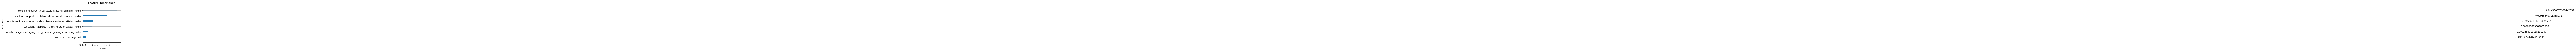

In [12]:
plt.rcParams["figure.figsize"] = (3, 3)
plot_importance(model, importance_type = 'gain') 
plt.show()

In [13]:
importances = model.get_booster().get_score(importance_type = 'gain')

def scoring(row, importances, f_RR):
    
    """
    Score = f_RR * RR_medio + sum from 1 to Nfeats Weighted feature value 
    weight of feature = [(1 - f_RR) / sum of all importances] x importance of the feature
    """
    
    total_importance = sum(importances.values())
    factor = (1 - f_RR) / total_importance
    
    return f_RR*row["RR_medio"] + sum([factor*I*row[col] for col, I in importances.items()])

In [14]:
N = 10
#scaler = MinMaxScaler(feature_range = (1,100))

for k in range(0, N+1):
    df[f"score_{k}"] = df[new_cols + ["RR_medio"]].apply(lambda row: scoring(row, importances, f_RR = k/N), axis = 1)
    #df[f"diff_{k}"] = df[f"score_{k}"] - df[f"RR_medio"]
    #df[f"scaled_score_{k}"] = scaler.fit_transform(df[f"score_{k}"].values.reshape(-1, 1))   

In [15]:
df = df.sort_values(by = "data", ignore_index = True)

In [16]:
rank_path = f"{path}/rankings_window_{window}_days_{date_interval}_{info}.csv"
save_df = df[["data", "id_consulente"] + [col for col in df.columns if "score" in col]]
save_df.to_csv(rank_path, index = False)